### 1. import dataset and load sample

In [108]:
from datasets import load_dataset

dataset = load_dataset("bavard/personachat_truecased", "sample")
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['personality', 'candidates', 'history', 'conv_id', 'utterance_idx'],
        num_rows: 14
    })
    validation: Dataset({
        features: ['personality', 'candidates', 'history', 'conv_id', 'utterance_idx'],
        num_rows: 15
    })
})


In [109]:
print(dataset["train"][0])
    

{'personality': ['I like to remodel homes.', 'I like to go hunting.', 'I like to shoot a bow.', 'My favorite holiday is halloween.'], 'candidates': ['My mom was single with 3 boys, so we never left the projects.', 'I try to wear all black every day. It makes me feel comfortable.', 'Well nursing stresses you out so I wish luck with sister.', 'Yeah just want to pick up Nba nfl getting old.', 'I really like Celine Dion. What about you?', 'No. I live near farms.', "I wish I had a daughter, I'm a boy mom. They're beautiful boys though still lucky.", 'Yeah when I get bored I play gone with the wind my favorite movie.', "Hi how are you? I'm eating dinner with my hubby and 2 kids.", 'Were you married to your high school sweetheart? I was.', 'That is great to hear! Are you a competitive rider?', "Hi, I'm doing ok. I'm a banker. How about you?", "I'm 5 years old.", 'Hi there. How are you today?', 'I totally understand how stressful that can be.', 'Yeah sometimes you do not know what you are actu

### 2. Define history conversation, response, and persona

In [110]:
#select conversation with certain id
conv_id = 6
dataset = load_dataset("bavard/personachat_truecased", "full")
dialog = dataset.filter(lambda example:example['conv_id']== conv_id)


In [111]:
#select persona 
persona = dialog['train']['personality'][-1]
print("User Persona: ", persona, "\n")

#select the history conversation
history_convo = dialog['train']['history'][-1]
print("History Conversation: ", history_convo, "\n")

#select the response
usr_response = dialog['train']['candidates'][-1][-1]
print("Response: ",usr_response)


User Persona:  ['I have a boxer dog.', 'I like baths.', 'I like to listen to music.', 'My father lives in China.'] 

History Conversation:  ["Rock on, I'm listening to my favorite band guns and roses.", 'No kidding? I was just listening to the same thing while taking a bath.', 'Of course. I love to listen to rock.', 'Man my boxer just peed on the carpet!', "Well I'm into black everything. So at least it wouldn't show on my black carpet.", 'Ll. I love black too! Guess I was playing my music too loud.', "I've a black car, purse, wear all black.", 'Maybe I can borrow something as I am packing to visit my dad in China.', 'Wow, does he live there or work?', 'Live. Moved there about ten years ago for a computer tech job.', 'Have you visited him there before?', 'Once. You cannot even throw a gum wrapper or you can get arrested.', 'Sounds a bit scary. I ve never been.'] 

Response:  Well not too much crime there, but a lot of people.


### 3. Preprocess the text to make it suitable for prompting

In [125]:
#preprocess the persona
persona_processed = "User Persona: \n"
for sen in persona:
    persona_processed += sen + "\n"

#preprocess the history conversation
history_convo_processed = "Dialogue history: \n"

#concat all history except the last utter from the bot
for i in range(0,len(history_convo)-1,2):
    bot_uttr = "Bot: " + history_convo[i]
    user_uttr = "User: " + history_convo[i+1]
    full_uttr = bot_uttr + "\n" + user_uttr + "\n"
    history_convo_processed += full_uttr

#add the last utter from bot
history_convo_processed += "Bot: " + history_convo[-1] + "\n"

#concat prompt
prompt = persona_processed + "\n" + history_convo_processed + "\nResponse\nUser:"
print(prompt)

Dialogue history: 
Bot: Rock on, I'm listening to my favorite band guns and roses.
User: No kidding? I was just listening to the same thing while taking a bath.
Bot: Of course. I love to listen to rock.
User: Man my boxer just peed on the carpet!
Bot: Well I'm into black everything. So at least it wouldn't show on my black carpet.
User: Ll. I love black too! Guess I was playing my music too loud.
Bot: I've a black car, purse, wear all black.
User: Maybe I can borrow something as I am packing to visit my dad in China.
Bot: Wow, does he live there or work?
User: Live. Moved there about ten years ago for a computer tech job.
Bot: Have you visited him there before?
User: Once. You cannot even throw a gum wrapper or you can get arrested.
Bot: Sounds a bit scary. I ve never been.

Response
User:


In [126]:
import os
from openai import OpenAI

os.environ['OPENAI_API_KEY'] = 'sk-proj-zgpS1dH01GeQiQzhICjNT3BlbkFJq8oC1i8atPEckRUxahYK'
client = OpenAI()

response = client.chat.completions.create(
    model="gpt-3.5-turbo",  # Specify the model
    messages=[
        {"role": "system", "content": "According to the history conversation provided, pretend to speak like a human user and generate a response."},
        {"role": "user", "content": prompt}
    ],
    temperature=0,  # Adjust based on how creative you want the AI to be
    max_tokens=150, # Adjust based on how long you expect responses to be
)


In [127]:
import json
print(json.dumps(json.loads(response.model_dump_json()), indent=4))


{
    "id": "chatcmpl-9ikTtLOpcukHYtnHPaUuqlCtz9enM",
    "choices": [
        {
            "finish_reason": "stop",
            "index": 0,
            "logprobs": null,
            "message": {
                "content": "China is definitely a unique experience with its strict rules. It's important to be mindful of the cultural differences when visiting.",
                "role": "assistant",
                "function_call": null,
                "tool_calls": null
            }
        }
    ],
    "created": 1720452133,
    "model": "gpt-3.5-turbo-0125",
    "object": "chat.completion",
    "service_tier": null,
    "system_fingerprint": null,
    "usage": {
        "completion_tokens": 24,
        "prompt_tokens": 233,
        "total_tokens": 257
    }
}


In [128]:
response_chatgpt = response.choices[0].message.content

print(response_chatgpt)

print(usr_response)

China is definitely a unique experience with its strict rules. It's important to be mindful of the cultural differences when visiting.
Well not too much crime there, but a lot of people.


In [273]:
from datasets import load_dataset
import random

def get_random_conv_id(pool, num_conv):
    random_values = random.sample(pool, num_conv)

    for value in random_values:
        pool.remove(value)
    
    return random_values

def extract_format_data(dataset, conv_id):
    dialog = dataset.filter(lambda example:example['conv_id']== conv_id)

    persona = dialog['train']['personality'][-1]
    history_convo = dialog['train']['history'][-1]
    usr_response = dialog['train']['candidates'][-1][-1]

    #preprocess the persona
    persona_processed = "User Persona: \n"
    for sen in persona:
        persona_processed += sen + "\n"

    #preprocess the history conversation
    history_convo_processed = "Dialogue history: \n"

    #concat all history except the last utter from the bot
    for i in range(0,len(history_convo)-1,2):
        bot_uttr = "Bot: " + history_convo[i]
        user_uttr = "User: " + history_convo[i+1]
        full_uttr = bot_uttr + "\n" + user_uttr + "\n"
        history_convo_processed += full_uttr

    #add the last utter from bot
    history_convo_processed += "Bot: " + history_convo[-1] + "\n"

    #preprocess the user response
    usr_response_processed = "Response\nUser: " + usr_response + "\n"
    return [persona_processed, history_convo_processed, usr_response_processed]

def create_example(dataset, conv_id, implicit=False):
    materials = extract_format_data(dataset, conv_id)
    if implicit:
        return materials[1] + materials[2]
    else:
        return materials[0] + materials[1] + materials[2]
    return example

def create_few_shot_examples(dataset, conv_id, few_shot_no, implicit=False):
    max_conv_id = dataset['train']['conv_id'][-1]
    pool = [num for num in range(1, max_conv_id + 1) if num != conv_id]
    random_conv_ids = get_random_conv_id(pool, few_shot_no)

    few_shot_examples = ""
    for index, conv_id in enumerate(random_conv_ids):
        few_shot_examples += f"Demo {index}:\n" + create_example(dataset, conv_id, implicit) + "\n"
    return few_shot_examples


def construct_prompt(dataset, conv_id, prompt_type, few_shot_no):
    max_conv_id = dataset['train']['conv_id'][-1]
    materials = extract_format_data(dataset, conv_id)
    system_prompt = ""
    user_prompt = ""
    few_shot_examples = ""

    if prompt_type == "context_only":
        user_prompt += materials[1] + "User:"

    if prompt_type == "task_prompt_context_implicit":
        system_prompt += "According to the history conversation provided, pretend to speak like a human user and generate a response."
        user_prompt += materials[1] + "User:"

    if prompt_type == "task_prompt_context_explicit":
        system_prompt += "According to the persona and history conversation provided, pretend to speak like a human user and generate a response."
        user_prompt += materials[0]+ materials[1] + "User:"

    if prompt_type == "few_shot_implicit":
        system_prompt += "According to the few shot demos provided, pretend to speak like User and generate a response matching the context."

        few_shot_examples = create_few_shot_examples(dataset, conv_id, few_shot_no,implicit=True)
        user_prompt += few_shot_examples + materials[1]+ "User:"

    return system_prompt, user_prompt, materials[2]

In [277]:
dataset = load_dataset("bavard/personachat_truecased", "full")
system_p, user_p, target_response = construct_prompt(dataset, 6, "few_shot_implicit", 1)

Filter: 100%|██████████| 7801/7801 [00:00<00:00, 52893.94 examples/s]


In [278]:
system_p

'According to the few shot demos provided, pretend to speak like User and generate a response matching the context.'

In [283]:
import os
from openai import OpenAI

os.environ['OPENAI_API_KEY'] = 'sk-proj-zgpS1dH01GeQiQzhICjNT3BlbkFJq8oC1i8atPEckRUxahYK'
client = OpenAI()

def prompt_chatgpt(prompt_type, conv_id, few_shot_no=0):
    dataset = load_dataset("bavard/personachat_truecased", "full")
    system_prompt, user_prompt, target_response= construct_prompt(dataset, conv_id, prompt_type, few_shot_no)
    response = client.chat.completions.create(
        model="gpt-3.5-turbo-16k",  # Specify the model
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt}
        ],
        temperature=0.9,  # Adjust based on how creative you want the AI to be
        max_tokens=15, # Adjust based on how long you expect responses to be
    )
    return response.choices[0].message.content, user_prompt, target_response



In [284]:
response, user_prompt, target_repsonse= prompt_chatgpt("task_prompt_context_explicit", 6)

In [287]:
print(user_prompt)
print(response)
print(target_repsonse)

User Persona: 
I have a boxer dog.
I like baths.
I like to listen to music.
My father lives in China.
Dialogue history: 
Bot: Rock on, I'm listening to my favorite band guns and roses.
User: No kidding? I was just listening to the same thing while taking a bath.
Bot: Of course. I love to listen to rock.
User: Man my boxer just peed on the carpet!
Bot: Well I'm into black everything. So at least it wouldn't show on my black carpet.
User: Ll. I love black too! Guess I was playing my music too loud.
Bot: I've a black car, purse, wear all black.
User: Maybe I can borrow something as I am packing to visit my dad in China.
Bot: Wow, does he live there or work?
User: Live. Moved there about ten years ago for a computer tech job.
Bot: Have you visited him there before?
User: Once. You cannot even throw a gum wrapper or you can get arrested.
Bot: Sounds a bit scary. I ve never been.
User:
It can be a bit intimidating at times, but overall it's a fascinating
Response
User: Well not too much crim

In [286]:
response

"It can be a bit intimidating at times, but overall it's a fascinating"

In [167]:
max_conv_id = len(dataset['train']['conv_id'])
print(max_conv_id)

131438


In [154]:
print(example)

User Persona: 
I have a boxer dog.
I like baths.
I like to listen to music.
My father lives in China.
Dialogue history: 
Bot: Rock on, I'm listening to my favorite band guns and roses.
User: No kidding? I was just listening to the same thing while taking a bath.
Bot: Of course. I love to listen to rock.
User: Man my boxer just peed on the carpet!
Bot: Well I'm into black everything. So at least it wouldn't show on my black carpet.
User: Ll. I love black too! Guess I was playing my music too loud.
Bot: I've a black car, purse, wear all black.
User: Maybe I can borrow something as I am packing to visit my dad in China.
Bot: Wow, does he live there or work?
User: Live. Moved there about ten years ago for a computer tech job.
Bot: Have you visited him there before?
User: Once. You cannot even throw a gum wrapper or you can get arrested.
Bot: Sounds a bit scary. I ve never been.
Response:
User: Well not too much crime there, but a lot of people.


In [245]:
from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
scores = scorer.score('The quick brown fox jumps over the lazy dog',
                      'The quick brown dog jumps on the log.')

In [250]:
scores['rouge1'].fmeasure

0.7058823529411765

In [252]:
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def p_cover(persona, response):
    # Tokenize and remove stop words
    persona_tokens = [word for word in nltk.word_tokenize(persona.lower()) if word.isalnum() and word not in stop_words]
    response_tokens = [word for word in nltk.word_tokenize(response.lower()) if word.isalnum() and word not in stop_words]
    
    # Calculate TF-IDF for the persona terms
    vectorizer = TfidfVectorizer(vocabulary=set(persona_tokens))
    tfidf_matrix = vectorizer.fit_transform([response])
    
    # Extract the TF-IDF scores for the persona terms in the response
    tfidf_scores = tfidf_matrix.toarray()[0]
    
    # Calculate the P-Cover score
    p_cover_score = sum(tfidf_scores) / len(persona_tokens)
    
    return p_cover_score

# Example usage
persona = "I love playing basketball and enjoy watching movies."
response = "Basketball is my favorite sport. I also love watching movies in my free time."

p_cover_score = p_cover(persona, response)
print(f"P-Cover Score: {p_cover_score}")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zarius/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


LookupError: 
**********************************************************************
  Resource [93mpunkt[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt/PY3/english.pickle[0m

  Searched in:
    - '/Users/zarius/nltk_data'
    - '/Users/zarius/miniconda3/envs/llm_persona/nltk_data'
    - '/Users/zarius/miniconda3/envs/llm_persona/share/nltk_data'
    - '/Users/zarius/miniconda3/envs/llm_persona/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
    - ''
**********************************************************************


In [258]:
import nltk
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction


# implementation of P-Cover
def calculate_p_cover(persona, response):
    return 0

# implementation of BLEU-1, BLEU-2, BLEU-3, and BLEU-4
def calculate_bleu(reference_sentence, candidate_sentence):
    reference = [reference_sentence.split()]
    candidate = candidate_sentence.split()
    
    # Weights for BLEU-1, BLEU-2, BLEU-3, and BLEU-4
    weights = [
        (1.0, 0, 0, 0),        
        (0.5, 0.5, 0, 0),        
        (1.0 / 3, 1.0 / 3, 1.0 / 3, 0), 
        (0.25, 0.25, 0.25, 0.25) 
    ]
    
    # Use smoothing to handle cases with few n-grams
    smoothing_function = SmoothingFunction()
    scores = sentence_bleu(reference, candidate, weights, smoothing_function=smoothing_function.method1)
    return scores

# rouge1, rouge2, rougeL
def calculate_rouge(reference_sentence, candidate_sentence):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(reference_sentence, candidate_sentence)
    return scores

def cosine_similarity_embeddings(sentence1, sentence2, model_name='all-MiniLM-L6-v2'):
    model = SentenceTransformer(model_name)
    embeddings = model.encode([sentence1, sentence2])
    cos_sim = cosine_similarity([embeddings[0]], [embeddings[1]])[0][0]
    return cos_sim

def distinct_1(sentence):
    words = sentence.split()
    unique_unigrams = set(words)
    total_unigrams = len(words)
    if total_unigrams == 0:
        return 0.0
    distinct_1_score = len(unique_unigrams) / total_unigrams
    return distinct_1_score

def distinct_2(sentence):
    words = sentence.split()
    bigrams = list(nltk.bigrams(words))
    unique_bigrams = set(bigrams)
    total_bigrams = len(bigrams)
    if total_bigrams == 0:
        return 0.0
    distinct_2_score = len(unique_bigrams) / total_bigrams
    return distinct_2_score

def calculate_metrics(reference_sentence, candidate_sentence):
    bleu_score = calculate_bleu(reference_sentence, candidate_sentence)
    rouge_scores = calculate_rouge(reference_sentence, candidate_sentence)
    cosine_similarity = cosine_similarity_embeddings(reference_sentence, candidate_sentence)
    distinct_1_score = distinct_1(candidate_sentence)
    distinct_2_score = distinct_2(candidate_sentence)

    return {
        'BLEU-1': bleu_score[0],
        'BLEU-2': bleu_score[1],
        'BLEU-3': bleu_score[2],
        'BLEU-4': bleu_score[3],
        'ROUGE-1': rouge_scores['rouge1'].fmeasure,
        'ROUGE-2': rouge_scores['rouge2'].fmeasure,
        'ROUGE-L': rouge_scores['rougeL'].fmeasure,
        'Cosine Similarity': cosine_similarity,
        'Distinct-1': distinct_1_score,
        'Distinct-2': distinct_2_score
    }


In [259]:
reference_sentence = "the cat is on the mat"
candidate_sentence = "the cat is on mat"
calculate_metrics(reference_sentence, candidate_sentence)

{'BLEU-1': 0.8187307530779819,
 'BLEU-2': 0.7090416310250969,
 'BLEU-3': 0.6498270293573523,
 'BLEU-4': 0.5789300674674098,
 'ROUGE-1': 0.9090909090909091,
 'ROUGE-2': 0.6666666666666665,
 'ROUGE-L': 0.9090909090909091,
 'Cosine Similarity': 0.9925266,
 'Distinct-1': 1.0,
 'Distinct-2': 1.0}

In [261]:
num_stories = 10
prompts = ["Once upon a time,"] * num_stories
stories = [""] * len(prompts)

In [262]:
stories

['', '', '', '', '', '', '', '', '', '']

In [272]:
from openai import OpenAI

client = OpenAI()

def prompt_chatgpt_batch(prompt_type, conv_ids, few_shot_no):
    dataset = load_dataset("bavard/personachat_truecased", "full")
    
    system_prompts = []
    user_prompts = []
    target_responses = []

    # Collect prompts for all conversation IDs
    for conv_id in conv_ids:
        system_prompt, user_prompt, target_response = construct_prompt(dataset, conv_id, prompt_type, few_shot_no)
        system_prompts.append(system_prompt)
        user_prompts.append(user_prompt)
        target_responses.append(target_response)
    
    # Create batch messages for the API request
    messages = [{"role": "system", "content": system_prompt} for system_prompt in system_prompts]
    messages += [{"role": "user", "content": user_prompt} for user_prompt in user_prompts]

    response = client.chat.completions.create(
        model="gpt-3.5-turbo-16k",
        messages=messages,
        temperature=0.9,
        max_tokens=15,  # since persona-chat sets a maximum of 15 words per message
    )
    
    # Process responses and match to the original prompts
    responses = ["" for _ in conv_ids]
    for i, choice in enumerate(response.choices):
        index = i % len(conv_ids)
        responses[index] = choice.message.content
    
    # Combine responses with user prompts and target responses
    batch_responses = []
    for i in range(len(conv_ids)):
        batch_responses.append({
            "response": responses[i],
            "target_response": target_responses[i],
            "user_prompt": user_prompts[i]
        })
    
    return batch_responses

# Example usage:
conv_ids = [1]  # Replace with actual conversation IDs
prompt_type = "context_only"
few_shot_no = 0

batch_results = prompt_chatgpt_batch(prompt_type, conv_ids, few_shot_no)
for result in batch_results:
    print(f"User Prompt: {result['user_prompt']}")
    print(f"Response: {result['response']}")
    print(f"Target Response: {result['target_response']}")
    print()

User Prompt: Dialogue history: 
Bot: Hi, how are you doing today?
User: I am spending time with my 4 sisters what are you up to.
Bot: Wow, four sisters. Just watching game of thrones.
User: That is a good show I watch that while drinking iced tea.
Bot: I agree. What do you do for a living?
User: I'm a researcher I'm researching the fact that mermaids are real.
Bot: Interesting. I'm a website designer. Pretty much spend all my time on the computer.
User: That's cool my mom does the same thing.
Bot: That's awesome. I have always had a love for technology.
User: Tell me more about yourself.
Bot: I really enjoy free diving, how about you, have any hobbies?
User: I enjoy hanging with my mother she's my best friend.
Bot: That's nice. Moms are pretty cool too.
User:
Response: Yes, they are. I'm really lucky to have such a close relationship
Target Response: Response
User: I'm also fascinated with mermaids.




In [271]:
print(batch_results[0]['response'])

Dialogue history: 
Bot: Oh, mojitos are delicious. I


In [12]:
import random
from datasets import load_dataset

def get_random_conv_id(pool, num_conv):
    random_values = random.sample(pool, num_conv)

    for value in random_values:
        pool.remove(value)
    
    return random_values

def extract_format_data(dataset, conv_id):
    dialog = dataset.filter(lambda example:example['conv_id']== conv_id)

    persona = dialog['train']['personality'][-1]
    history_convo = dialog['train']['history'][-1]
    usr_response = dialog['train']['candidates'][-1][-1]

    unprocessed = [persona, history_convo, usr_response]

    #preprocess the persona
    persona_processed = "User Persona: \n"
    for sen in persona:
        persona_processed += sen + "\n"

    #preprocess the history conversation
    history_convo_processed = "Dialogue history: \n"
    
    #concat all history except the last utter from the bot
    for i in range(0,len(history_convo)-1,2):
        bot_uttr = "Bot: " + history_convo[i]
        user_uttr = "User: " + history_convo[i+1]
        full_uttr = bot_uttr + "\n" + user_uttr + "\n"
        history_convo_processed += full_uttr

    #add the last utter from bot
    history_convo_processed += "Bot: " + history_convo[-1] + "\n"

    #preprocess the user response
    usr_response_processed = "User: " + usr_response + "\n"

    processed = [persona_processed, history_convo_processed, usr_response_processed]
    return unprocessed, processed

# materials[0] is persona, materials[1] is history conversation, materials[2] is user response
def create_example(dataset, conv_id, implicit=False):
    _, materials = extract_format_data(dataset, conv_id)
    if implicit:
        return materials[1] + materials[2]
    else:
        return materials[0] + materials[1] + materials[2]
    

def create_few_shot_examples(dataset, conv_id, few_shot_no, implicit=False):
    max_conv_id = dataset['train']['conv_id'][-1]
    pool = [num for num in range(1, max_conv_id + 1) if num != conv_id]
    random_conv_ids = get_random_conv_id(pool, few_shot_no)

    few_shot_examples = ""
    for index, conv_id in enumerate(random_conv_ids):
        few_shot_examples += f"Demo {index}:\n" + create_example(dataset, conv_id, implicit) + "\n"
    return few_shot_examples


def construct_prompt(dataset, conv_id, prompt_type, few_shot_no=1, print_output= False):
    max_conv_id = dataset['train']['conv_id'][-1]
    raw_materials, materials = extract_format_data(dataset, conv_id)
    raw_target_response = raw_materials[2]
    raw_persona_text = raw_materials[0]

    system_prompt = ""
    user_prompt = ""
    few_shot_examples = ""

    # only history dialogue
    if prompt_type == "context_only":
        user_prompt += materials[1] + "User:"

    # task prompt, history dialogue
    if prompt_type == "task_prompt_context_implicit":
        #version 1 Based on the previous conversation history, generate a response for the user that aligns with their profile and the current context of the discussion.
        system_prompt += "Considering the user's profile and the ongoing discussion's context as established in the previous dialogue history, craft a response within 15 words that is coherent, relevant, and tailored to the user's interests and style of communication."
        user_prompt += materials[1] + "User:"

    # task prompt, persona, and history dialogue
    if prompt_type == "task_prompt_context_explicit":
        system_prompt += "Given the user's profile as outlined in the provided persona information, and considering the context of the ongoing discussion from the previous dialogue history, craft a response that is specifically tailored to resonate with the user's explicit characteristics and maintains the continuity of the dialogue."
        user_prompt += materials[0]+ materials[1] + "User:"

    # few-shot demos, history dialogue
    if prompt_type == "few_shot_implicit":
        system_prompt += "Considering the various user profiles and styles depicted in the provided few-shot examples, and the ongoing discussion's context as established in the previous dialogue history, synthesize a coherent and relevant response. This response should be adaptable to the general preferences and communication styles observed in the examples, while seamlessly continuing the dialogue."

        #set the implicit flag to True to exclude persona in few-shot demos
        few_shot_examples = create_few_shot_examples(dataset, conv_id, few_shot_no, implicit=True)
        user_prompt += few_shot_examples + materials[1]+ "User:"

    if print_output:
        print("### TASK PROMPT ###\n" + system_prompt)
        print("### USER PROMPT ###\n" + user_prompt)
    

    return system_prompt, user_prompt, raw_target_response, raw_persona_text


#context_only, task_prompt_context_implicit, task_prompt_context_explicit, few_shot_implicit
def test():
    dataset = load_dataset("bavard/personachat_truecased", "full")
    dataset
    result = construct_prompt(dataset, 1, "task_prompt_context_implicit",print_output=False)
    return result


/Users/zarius/miniconda3/envs/llm_persona/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [26]:
def test():
    name = "1"
    name2 = "2"

    return name, name2

result = test()

In [29]:
result[0]

'1'

In [73]:
conv_id = 6
dataset = load_dataset("bavard/personachat_truecased", "full")
#dialog = dataset['validation'].filter(lambda example:example['conv_id']== conv_id)


In [74]:
dataset

DatasetDict({
    train: Dataset({
        features: ['personality', 'candidates', 'history', 'conv_id', 'utterance_idx'],
        num_rows: 131438
    })
    validation: Dataset({
        features: ['personality', 'candidates', 'history', 'conv_id', 'utterance_idx'],
        num_rows: 7801
    })
})

In [1]:
from helper import read_json
data = read_json('experiment1')

In [2]:
from analyze import calculate_metrics
calculate_metrics(data[-1]['conv_id'], data[-1]['target_response'], data[-1]['generated_response'], data[-1]['persona_text'])

/Users/zarius/miniconda3/envs/llm_persona/lib/python3.9/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


{'Conversation ID': 965,
 'BLEU-1': 0,
 'BLEU-2': 0,
 'BLEU-3': 0,
 'BLEU-4': 0,
 'ROUGE-1': 0.0,
 'ROUGE-2': 0.0,
 'ROUGE-L': 0,
 'Cosine Similarity': 0.20438892,
 'Distinct-1': 0.0,
 'Distinct-2': 0.0,
 'Token Overlap Ratio': 0.0,
 'Character Overlap Ratio': 0.0,
 'Inter Similarity': 0.04087778329849243,
 'Persona Coverage': 0,
 'Persona Recall': 0,
 'Persona Precision': 0,
 'Persona F1': 0}

In [2]:
metric_keys = data[0].keys()
print(metric_keys)

dict_keys(['Conversation ID', 'BLEU-1', 'BLEU-2', 'BLEU-3', 'BLEU-4', 'ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'Cosine Similarity', 'Distinct-1', 'Distinct-2', 'Token Overlap Ratio', 'Character Overlap Ratio', 'Inter Similarity', 'Persona Coverage', 'Persona Recall', 'Persona Precision', 'Persona F1'])


In [7]:
def calculate_avg_metrics(data):
    avg_metrics = {
        'Conversation ID': 0,
        'BLEU-1': 0,
        'BLEU-2': 0,
        'BLEU-3': 0,
        'BLEU-4': 0,
        'ROUGE-1': 0,
        'ROUGE-2': 0,
        'ROUGE-L': 0,
        'Cosine Similarity': 0,
        'Distinct-1': 0,
        'Distinct-2': 0,
        'Token Overlap Ratio': 0,
        'Character Overlap Ratio': 0,
        'Inter Similarity': 0,
        'Persona Coverage': 0,
        'Persona Recall': 0,
        'Persona Precision': 0,
        'Persona F1': 0
    }
    for object in data:
        for key in object.keys():
            avg_metrics[key] += object[key]
    
    num_objects = len(data)
    for key in avg_metrics.keys():
        avg_metrics[key] /= num_objects 
        avg_metrics[key] = avg_metrics[key]*100
    return avg_metrics

avg_metrics = calculate_avg_metrics(data)
            


In [9]:
from analyze import print_avg_metrics
print_avg_metrics("experiment1_metrics")

{'Conversation ID': 499.5, 'BLEU-1': 0.1232292348429177, 'BLEU-2': 0.049328470627085876, 'BLEU-3': 0.0289745832318289, 'BLEU-4': 0.021344028967990904, 'ROUGE-1': 0.1561807770889836, 'ROUGE-2': 0.02986322457413851, 'ROUGE-L': 0.13987661453868921, 'Cosine Similarity': 0.30141694619180637, 'Distinct-1': 0.9554821806637072, 'Distinct-2': 0.9981878124227666, 'Token Overlap Ratio': 0.09041412052169583, 'Character Overlap Ratio': 0.5681395475299307, 'Inter Similarity': 0.2446152927250076, 'Persona Coverage': 0.0609735787729655, 'Persona Recall': 0.2592147019647016, 'Persona Precision': 0.12054429566079165, 'Persona F1': 0.1550908013546865}


In [58]:
dataset['validation']['history'][-1]

['Hi how are you?',
 'I am doing great on this crisp fall night.',
 'Do you like sports? I love tennis and play it for a living.',
 'Sports are ok but I love cooking shows and cooking.',
 'My husband is a doctor so I cook meals and freeze them to have on hand.',
 'That is a great idea I am single so I only make enough for one.',
 'Well enjoy being single, we are growing our family so free time is short.',
 'But it is tough cause I am vegan and my friends are not.',
 'Bummer, I take my dog for long walks to De stress, how about you?',
 'I like to go skydiving or ride a rollercoaster.',
 'When its raining or too cold we walk the stairs in our home, three stories!',
 'Wow first floor apt for me so no stairs.',
 'With a big family we need the room, plus the dog.',
 'How many children do u have.',
 'Three and one on the way. The dog is like a child too.']

In [11]:
import math
import gensim.downloader as api
import spacy
tokenizer = spacy.load('en_core_web_sm')

def tokenize(text):
    doc = tokenizer(text)
    # Filter out punctuation and stop words
    return [token.text.lower() for token in doc if token.is_alpha or token.is_digit]

def calculate_idf(tf_j):
    """Calculate the inverse document frequency (idf) for a given term frequency (tf_j)."""
    return 1 / (1 + math.log(1 + tf_j))

def calculate_tf(idx):
    """Calculate the term frequency (tf) using Zipf's Law for a Glove-twitter-100 index (idx)."""
    return 1e6 * (1 / (idx ** 1.07))

def calculate_persona_coverage(response, personas, glove_model):
    """
    Calculate Persona Coverage.
    
    Args:
    response (str): The generated response sentence.
    personas (list): A list of persona sentences.
    glove_model: Pre-trained GloVe model from gensim.
    
    Returns:
    float: The Persona Coverage score.
    """
    # Tokenize the response and persona sentences
    W_Y = set(response.split())
    
    # Initialize the maximum persona coverage score
    max_p_cover = 0
    
    # Iterate over each persona sentence
    for persona in personas:
        W_p_i = set(persona.split())
        
        # Calculate the intersection of words between response and persona
        intersection = W_Y.intersection(W_p_i)
        
        if not intersection:
            continue
        
        # Calculate the sum of idf values for words in the intersection
        sum_idf = 0
        for word in intersection:
            if word in glove_model.key_to_index:
                idx = glove_model.key_to_index[word] + 1  # GloVe index is 0-based, so add 1
                tf = calculate_tf(idx)
                idf = calculate_idf(tf)
                sum_idf += idf
        
        # Normalize by the size of the intersection
        p_cover = sum_idf / len(intersection)
        
        # Update the maximum persona coverage score
        if p_cover > max_p_cover:
            max_p_cover = p_cover
    
    return max_p_cover

def calculate_persona_recall(response, personas):
    """
    Calculate Persona Recall.
    
    Args:
    response (str): The generated response sentence.
    personas (list): A list of persona sentences.
    
    Returns:
    float: The Persona Recall score.
    """
    W_Y = set(tokenize(response))
    max_recall = 0
    print(W_Y)
    for persona in personas:
        W_p_i = set(tokenize(persona))
        intersection = W_Y & W_p_i
        recall = len(intersection) / len(W_p_i)
        if recall > max_recall:
            max_recall = recall

    return max_recall

def calculate_persona_precision(response, personas):
    """
    Calculate Persona Precision.
    
    Args:
    response (str): The generated response sentence.
    personas (list): A list of persona sentences.
    
    Returns:
    float: The Persona Precision score.
    """
    W_Y = set(tokenize(response))
    max_precision = 0

    for persona in personas:
        W_p_i = set(tokenize(persona))
        intersection = W_Y & W_p_i
        precision = len(intersection) / len(W_Y)
        if precision > max_precision:
            max_precision = precision

    return max_precision

def calculate_p_f1(response, personas):
    """
    Calculate P-F1.
    
    Args:
    response (str): The generated response sentence.
    personas (list): A list of persona sentences.
    
    Returns:
    float: The P-F1 score.
    """
    recall = calculate_persona_recall(response, personas)
    precision = calculate_persona_precision(response, personas)
    if recall + precision == 0:
        return 0
    p_f1 = 2 * recall * precision / (recall + precision)
    return p_f1

# Load the GloVe model from gensim
print("Loading GloVe model...")
glove_model = api.load("glove-twitter-100")  # You can choose other dimensions, e.g., 50, 200, 300

# Example usage:
response = "The cat sat on the mat"
personas = [
    "The cat is happy",
    "The dog sat on the log",
    "The cat chased the dog"
]

# Calculate Persona Coverage
persona_coverage = calculate_persona_coverage(response, personas, glove_model)
print("Persona Coverage:", persona_coverage)

# Calculate Persona Recall, Precision, and P-F1
persona_recall = calculate_persona_recall(response, personas)
persona_precision = calculate_persona_precision(response, personas)
p_f1 = calculate_p_f1(response, personas)

print("Persona Recall:", persona_recall)
print("Persona Precision:", persona_precision)
print("P-F1:", p_f1)

Loading GloVe model...
Persona Coverage: 0.08407729872580033
{'the', 'on', 'cat', 'sat', 'mat'}
{'the', 'on', 'cat', 'sat', 'mat'}
Persona Recall: 0.6
Persona Precision: 0.6
P-F1: 0.6


In [3]:
response = "The cat sat on the mat!"
response.split()

['The', 'cat', 'sat', 'on', 'the', 'mat!']

In [102]:
result = test()

In [106]:
print(result[3][0])

My mom is my best friend.


In [2]:
values = range(1,2)

In [4]:
for value in range(1,2):
    print(value)

1


In [15]:

# n-gram individual BLEU
from nltk.translate.bleu_score import sentence_bleu
reference = [['this', 'is', 'one', 'test']]
candidate = ['this', 'is', 'a', 'test']
print('Individual 1-gram: %f' % sentence_bleu(reference, candidate, weights=(1, 0, 0, 0)))
print('Individual 2-gram: %f' % sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0)))
print('Individual 3-gram: %f' % sentence_bleu(reference, candidate, weights=(0, 0, 1, 0)))
print('Individual 4-gram: %f' % sentence_bleu(reference, candidate, weights=(0, 0, 0, 1)))

Individual 1-gram: 0.750000
Individual 2-gram: 0.500000
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000


/Users/zarius/miniconda3/envs/llm_persona/lib/python3.9/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/zarius/miniconda3/envs/llm_persona/lib/python3.9/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


In [16]:
import spacy
nlp = spacy.load('en_core_web_sm')

def tokenize(text):
    """ Tokenizes the input text using spaCy and returns a list of token texts. """
    doc = nlp(text)
    return [token.text for token in doc]

tokens = tokenize("Hello, world! How are you doing today?")

In [20]:
tokens
sentence = "Hello, world! How are you doing today?"
result = [sentence.split()]

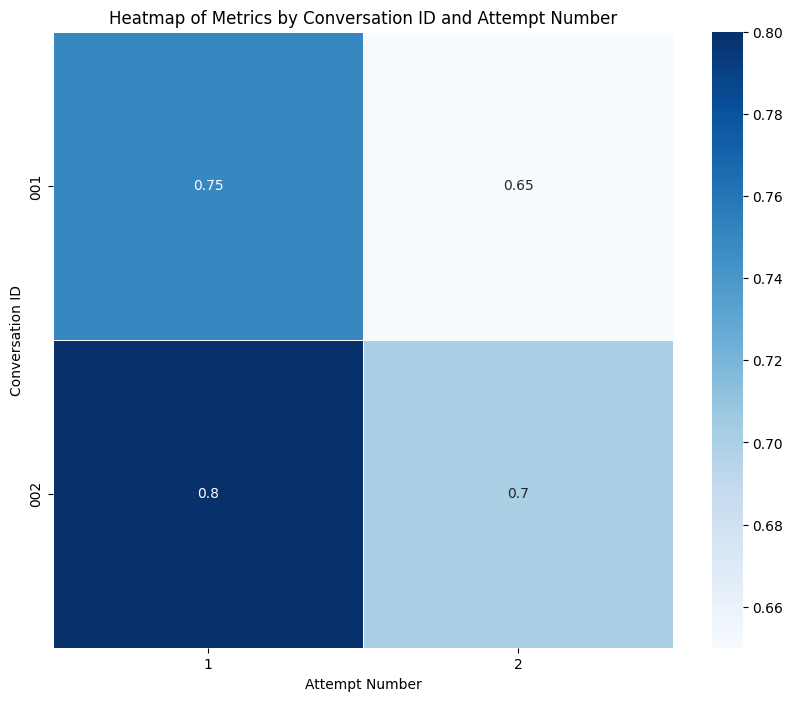

In [28]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Sample data in the specified dictionary format
data = [
    {"conv_id": "001", "attempt_no": 1, "generated_response": "Hello", "target_response": "Hi", "metrics": 0.75},
    {"conv_id": "001", "attempt_no": 2, "generated_response": "How are you?", "target_response": "How's it going?", "metrics": 0.65},
    {"conv_id": "002", "attempt_no": 1, "generated_response": "I'm fine", "target_response": "I am good", "metrics": 0.80},
    {"conv_id": "002", "attempt_no": 2, "generated_response": "What's up?", "target_response": "What is happening?", "metrics": 0.70}
]

# Convert list of dictionaries to DataFrame
df = pd.DataFrame(data)

# Pivot the DataFrame correctly using keyword arguments
heatmap_data = df.pivot(index="conv_id", columns="attempt_no", values="metrics")

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap
sns.heatmap(heatmap_data, annot=True, cmap='Blues', linewidths=.5)

# Add labels and title if necessary
plt.title('Heatmap of Metrics by Conversation ID and Attempt Number')
plt.xlabel('Attempt Number')
plt.ylabel('Conversation ID')

# Show the plot
plt.show()


In [26]:
df

,conv_id,attempt_no,generated_response,target_response,metrics
0,001,1,Hello,Hi,0.75
1,001,2,How are you?,How's it going?,0.65
2,002,1,I'm fine,I am good,0.80
3,002,2,What's up?,What is happening?,0.70


In [42]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
sentence1 = "Hello"
sentence2 = "Hi"
model_name='all-MiniLM-L6-v2'
model = SentenceTransformer(model_name)
embeddings = model.encode([sentence1, sentence2])
cos_sim = cosine_similarity([embeddings[0]], [embeddings[1]])


In [44]:
embeddings[0].shape

(384,)

In [ ]:
def cosine_similarity_embeddings(sentence1, sentence2, model_name='all-MiniLM-L6-v2'):
    model = SentenceTransformer(model_name)
    embeddings = model.encode([sentence1, sentence2])
    cos_sim = cosine_similarity([embeddings[0]], [embeddings[1]])[0][0]
    return cos_sim

In [85]:

dataset = load_dataset("bavard/personachat_truecased", "full")
cos_sim_list = []
for conv_id in range(0, 5):
    dialog = dataset.filter(lambda example:example['conv_id']== conv_id)
    persona = dialog['train']['personality'][-1]
    history_convo = dialog['train']['history'][-1]
    usr_response = dialog['train']['candidates'][-1][-1]
    print (usr_response)
    cos_sim = cosine_similarity_embeddings(usr_response,history_convo[-1])
    cos_sim_list.append(cos_sim)


If I have time outside of hunting and remodeling homes. Which is not much!


Filter: 100%|██████████| 7801/7801 [00:00<00:00, 44212.25 examples/s]


I'm also fascinated with mermaids.


Filter: 100%|██████████| 7801/7801 [00:00<00:00, 51856.29 examples/s]


Those are really yummy too, but not my favorite.


Filter: 100%|██████████| 7801/7801 [00:00<00:00, 58207.69 examples/s]


I doubt that very much. You probably like to scream alone.


Filter: 100%|██████████| 7801/7801 [00:00<00:00, 57068.30 examples/s]


That is awesome. Do you like it?


In [86]:
cos_sim_list

[0.14119357, 0.3144738, 0.427917, 0.27486795, 0.18668725]

In [75]:
### New metric to measure how likely the user is willing to start new topic
# start from 0 to indicate bot as first, start from 1 to indicate user as first
# 0 indicates how user 
cos_sim_list = []
for i in range(1,len(history_convo)-1,2):
    bot_uttr = history_convo[i]
    user_uttr =  history_convo[i+1]
    cos_sim = cosine_similarity_embeddings(bot_uttr, user_uttr)
    cos_sim_list.append(cos_sim)
    print(bot_uttr)
    print(user_uttr)
    

You must be very fast. Hunting is one of my favorite hobbies.
I am! For my hobby I like to do canning or some whittling.
I also remodel homes when I am not out bow hunting.
That's neat. When I was in high school I placed 6th in 100m dash!
That's awesome. Do you have a favorite season or time of year?
I do not. But I do have a favorite meat since that is all I eat exclusively.
What is your favorite meat to eat?
I would have to say its prime rib. Do you have any favorite foods?
I like chicken or macaroni and cheese.
Do you have anything planned for today? I think I am going to do some canning.
I am going to watch football. What are you canning?
I think I will can some jam. Do you also play footfall for fun?


In [74]:
# user's willingness 
cos_sim_list
avg_willingness = sum(cos_sim_list)/len(cos_sim_list)
print(avg_willingness)

0.42948577801386517


In [77]:
# bot's willingness
print(cos_sim_list)
avg_willingness = sum(cos_sim_list)/len(cos_sim_list)
print(avg_willingness)

[0.30346233, 0.018240921, 0.3325431, 0.73453104, 0.25507307, 0.23173182]
0.31259704753756523


In [78]:
from transformers import BertTokenizer, BertModel
import torch
from sklearn.metrics.pairwise import cosine_similarity

# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Function to get BERT embeddings for a sentence
def get_embedding(sentence):
    inputs = tokenizer(sentence, return_tensors='pt')
    outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).detach().numpy()

# Example conversation
conversation = [
    "Let's talk about the recent advancements in AI.",
    "Sure, AI has made significant progress in various fields.",
    "What do you think about machine learning?",
    "Machine learning is a subset of AI that focuses on algorithms."
]

# Compute embeddings for each sentence
embeddings = [get_embedding(sentence) for sentence in conversation]

# Measure semantic similarity between consecutive sentences
similarities = [cosine_similarity(embeddings[i], embeddings[i+1])[0][0] for i in range(len(embeddings)-1)]

# Define a threshold to detect topic drift (e.g., similarity below 0.7 indicates drift)
threshold = 0.7
topic_drift_points = [i for i, similarity in enumerate(similarities) if similarity < threshold]

print("Topic drift detected at sentence indices:", topic_drift_points)

Topic drift detected at sentence indices: [1, 2]


In [79]:
similarities

[0.7349808, 0.6413611, 0.6749538]

### Cornel Movie Dialogs Corpus

#### 1. load from huggingface

In [3]:
from datasets import load_dataset

dataset = load_dataset("cornell-movie-dialog/cornell_movie_dialog")
dataset['train'][4]

Generating train split: 100%|██████████| 83097/83097 [1:08:03<00:00, 20.35 examples/s]


#### 2. load from convokit

In [1]:
from convokit import Corpus, download
corpus = Corpus(filename=download("movie-corpus"))

In [43]:
num_of_utterances = 0
num_of_speakers = 0
conv_ids = []
conv_id = 0
 # only select conversation with 2 speakers and 12, 14, 16 utterances

while len(conv_ids) < 10:
    df = corpus.random_conversation().get_utterances_dataframe()
    num_of_utterances = df.shape[0]
    num_of_speakers = df['speaker'].nunique()
    conv_id = df['conversation_id'].iloc[0]
    #print("here")
    if ((num_of_utterances == 16 or num_of_utterances == 14 or num_of_utterances == 12) and (num_of_speakers == 2) and conv_id not in conv_ids):
        conv_ids.append(conv_id)
        print(conv_id)
        print(num_of_utterances)
print(df)

L637568
14
L552628
14
L406442
16
L221323
16
L357008
14
L396440
12
L267935
14
L484337
12
L147732
12
L356806
12
        timestamp                                   text speaker reply_to  \
id                                                                          
L356817      None  Zoe, come say hello to your father...   u6384  L356816   
L356816      None                                  Yeah.   u6378  L356815   
L356815      None           Do you want to talk to  Zoe?   u6384  L356814   
L356814      None                                  What?   u6378  L356813   
L356813      None                        Do you want to-   u6384  L356812   
L356812      None                               It's ok.   u6378  L356811   
L356811      None                  Fine. Is it going ok?   u6384  L356810   
L356810      None      I couldn't hear you. How are you?   u6378  L356809   
L356809      None                 It's Lydia, your wife.   u6384  L356808   
L356808      None                          

In [86]:
from convokit import Corpus, download
corpus = Corpus(filename=download("movie-corpus"))

In [116]:

filename = 'config.json'
# Load the updated content from the JSON file
with open(filename, 'r') as file:
    config_data = json.load(file)
# Access the list
conv_ids = config_data['conv_ids']
#print(f"The list loaded from {filename}: {conv_ids}")

conv_id = conv_ids[2]
    
#def construct_prompt_movie(corpus, conv_id):
system_prompt = ""
user_prompt = ""
persona_text = ""

convo_df = corpus.get_conversation(conv_id).get_utterances_dataframe()
#print(convo_df.head())
reversed_df = convo_df.iloc[::-1]

if len(reversed_df)>12:
    trimmed_df = reversed_df.head(12)
else:
    trimmed_df = reversed_df

# exclude the last utterance from the user
history_convo = trimmed_df['text'].iloc[:-1].tolist()
history_convo_processed = "Dialogue history: \n"

speakers = trimmed_df['speaker'].unique()

# Concat all history except the last utter from the user
for count, convo in enumerate(history_convo):
    if reversed_df['speaker'].iloc[count] == speakers[0]:
        bot_uttr = "Bot: " + convo
        history_convo_processed += bot_uttr + "\n"
    else :
        user_uttr = "User: " + convo
        history_convo_processed += user_uttr + "\n"
        
#print(history_convo_processed)

system_prompt += "Considering the user's profile and the ongoing discussion's context as established in the previous dialogue history, craft a response that is coherent, relevant, and tailored to the user's interests and style of communication."
system_prompt = ""
user_prompt += history_convo_processed + "User:"

# access the last user utterance
raw_target_response = trimmed_df['text'].iloc[-1]  
persona_text = raw_target_response 

print(user_prompt)
print(raw_target_response)


Dialogue history: 
Bot: I'm not good enough for her to associate with, am I? I'm not good enough to even talk about her, am I?
User: Let's drop it.
Bot: We're not dropping it. Now that's the reason, isn't it? I'm a dirty degenerate, aren't I? I'm not fit to --
User: Benjamin?
Bot: I'm good enough for you but I'm too slimy to associate with your daughter. That's it, isn't it? ISN'T IT?
User: Yes.
Bot: You go to hell. You go straight to hell, Mrs. Robinson. Do you think I'm proud of myself? Do you think I'm proud of this?
User: I wouldn't know.
Bot: Well, I'm not.
User: You're not.
Bot: No sir. I am not proud that I spend my time with a broken-down alcoholic!
User:
I see.


In [118]:

filename = 'config.json'
# Load the updated content from the JSON file
with open(filename, 'r') as file:
    config_data = json.load(file)
# Access the list
conv_ids = config_data['conv_ids']
#print(f"The list loaded from {filename}: {conv_ids}")

conv_id = conv_ids[2]
    
#def construct_prompt_movie(corpus, conv_id):
system_prompt = ""
user_prompt = ""
persona_text = ""

convo_df = corpus.get_conversation(conv_id).get_utterances_dataframe()
#print(convo_df.head())
reversed_df = convo_df.iloc[::-1]

if len(reversed_df)>12:
    trimmed_df = reversed_df.head(12)
else:
    trimmed_df = reversed_df
history_convo = trimmed_df['text'].iloc[:-1].tolist()
history_convo_processed = "Dialogue history: \n"

for i in range(0,len(history_convo)-1,2):
    bot_uttr = "Bot: " + history_convo[i]
    user_uttr = "User: " + history_convo[i+1]
    full_uttr = bot_uttr + "\n" + user_uttr + "\n"
    history_convo_processed += full_uttr

history_convo_processed += "Bot: " + history_convo[-1] + "\n"

system_prompt += "Considering the user's profile and the ongoing discussion's context as established in the previous dialogue history, craft a response that is coherent, relevant, and tailored to the user's interests and style of communication."
system_prompt = ""
user_prompt += history_convo_processed + "User:"

raw_target_response = trimmed_df['text'].iloc[-1]
persona_text = raw_target_response 

print(user_prompt)
print(raw_target_response)


Dialogue history: 
Bot: I'm not good enough for her to associate with, am I? I'm not good enough to even talk about her, am I?
User: Let's drop it.
Bot: We're not dropping it. Now that's the reason, isn't it? I'm a dirty degenerate, aren't I? I'm not fit to --
User: Benjamin?
Bot: I'm good enough for you but I'm too slimy to associate with your daughter. That's it, isn't it? ISN'T IT?
User: Yes.
Bot: You go to hell. You go straight to hell, Mrs. Robinson. Do you think I'm proud of myself? Do you think I'm proud of this?
User: I wouldn't know.
Bot: Well, I'm not.
User: You're not.
Bot: No sir. I am not proud that I spend my time with a broken-down alcoholic!
User:
I see.


In [104]:
reversed_df['speaker']

id
L251214    u1169
L251215    u1178
L251216    u1169
L251217    u1178
L251218    u1169
L251219    u1178
L251220    u1169
L251221    u1178
L251222    u1169
L251223    u1178
L251224    u1169
L251225    u1178
L251226    u1169
Name: speaker, dtype: object

In [97]:
print(user_prompt)

Dialogue history: 
Bot: I'm not good enough for her to associate with, am I? I'm not good enough to even talk about her, am I?
User: Let's drop it.
Bot: We're not dropping it. Now that's the reason, isn't it? I'm a dirty degenerate, aren't I? I'm not fit to --
User: Benjamin?
Bot: I'm good enough for you but I'm too slimy to associate with your daughter. That's it, isn't it? ISN'T IT?
User: Yes.
Bot: You go to hell. You go straight to hell, Mrs. Robinson. Do you think I'm proud of myself? Do you think I'm proud of this?
User: I wouldn't know.
Bot: Well, I'm not.
User: You're not.
Bot: No sir. I am not proud that I spend my time with a broken-down alcoholic!
User:


In [44]:
conv

['L637568', 'L552628', 'L406442', 'L221323', 'L357008', 'L396440', 'L267935', 'L484337', 'L147732', 'L356806']


In [31]:
import json
from convokit import Corpus, download
# Example list
my_list = conv_ids

# Specify the filename
filename = 'config.json'

# Read the existing JSON file
with open(filename, 'r') as file:
    config_data = json.load(file)

# Update the content with the new list
config_data['conv_ids'] = my_list

# Save the updated content back to the JSON file
with open(filename, 'w') as file:
    json.dump(config_data, file, indent=4)

print(f"The list has been added to {filename}")



The list has been added to config.json


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x103ad1580>>
Traceback (most recent call last):
  File "/Users/zarius/miniconda3/envs/llm_persona/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


In [1]:
import json

# Specify the filename
filename = 'conv_ids.json'

# Load the updated content from the JSON file
with open(filename, 'r') as file:
    config_data = json.load(file)

# Access the list
my_list = config_data['conv_ids']
# my_list = config_data.get('conv_ids', [])
print(f"The list loaded from {filename}: {my_list}")

The list loaded from conv_ids.json: ['L454941', 'L180354', 'L251214', 'L128625', 'L664756', 'L497911', 'L588539', 'L632293', 'L265335', 'L167136', 'L640833', 'L47235', 'L597564', 'L328385', 'L103999', 'L354236', 'L337910', 'L364492', 'L441274', 'L239974', 'L358595', 'L474694', 'L443546', 'L335958', 'L135631', 'L42761', 'L596994', 'L548610', 'L83351', 'L646100', 'L101788', 'L455157', 'L462109', 'L128757', 'L152309', 'L180084', 'L596875', 'L504704', 'L651979', 'L85061', 'L244522', 'L553861', 'L182826', 'L411980', 'L588582', 'L118269', 'L242526', 'L134737', 'L329709', 'L206109', 'L154337', 'L635524', 'L585973', 'L461929', 'L622686', 'L393238', 'L406007', 'L619627', 'L371374', 'L439131', 'L130313', 'L461851', 'L227726', 'L350305', 'L267688', 'L267613', 'L221392', 'L2196', 'L268127', 'L566912', 'L569606', 'L92892', 'L380349', 'L518568', 'L306609', 'L500677', 'L438750', 'L388025', 'L489466', 'L284619', 'L126945', 'L278322', 'L391671', 'L83140', 'L28427', 'L243978', 'L28284', 'L253763', 'L373

In [3]:
from convokit import Corpus, download
corpus = Corpus(filename=download("movie-corpus"))
df = corpus.get_conversation(my_list[0]).get_utterances_dataframe()


In [4]:
# reverse the order
reversed_df = df.iloc[::-1]
len(reversed_df)

if len(reversed_df)>12:
    trimmed_df = reversed_df.head(12)
history_convo = trimmed_df['text'].iloc[:-1].tolist()
print(len(history_convo))

history_convo = reversed_df['text'].iloc[:-1].tolist()
len(history_convo)

history_convo_processed = "Dialogue history: \n"

for i in range(0,len(history_convo)-1,2):
    bot_uttr = "Bot: " + history_convo[i]
    user_uttr = "User: " + history_convo[i+1]
    full_uttr = bot_uttr + "\n" + user_uttr + "\n"
    history_convo_processed += full_uttr

#add the last utter from bot
history_convo_processed += "Bot: " + history_convo[-1] + "\n"
print(history_convo_processed)

15

In [11]:
usr_response = trimmed_df['text'].iloc[-1]
print(usr_response)

I didn't lie.


In [26]:
conv_id = my_list[0]
prompt_type = "context_only"

system_prompt = ""
user_prompt = ""
persona_text = ""

convo_df = corpus.get_conversation(conv_id).get_utterances_dataframe()
reversed_df = convo_df.iloc[::-1]

if len(reversed_df)>=16:
    trimmed_df = reversed_df.head(16)
elif len(reversed_df)>=14:
    trimmed_df = reversed_df.head(14)
else:
    trimmed_df = reversed_df.head(12)

# get the speaker ids
speakers = trimmed_df['speaker'].unique()

# exclude the last utterance from the user
history_convo = trimmed_df['text'].iloc[:-1].tolist()
history_convo_processed = "Dialogue history: \n"

# Concat all history except the last utter from the user
for count, convo in enumerate(history_convo):
    if reversed_df['speaker'].iloc[count] == speakers[0]:
        bot_uttr = "Speaker0: " + convo
        history_convo_processed += bot_uttr + "\n"
    else :
        user_uttr = "Speaker1: " + convo
        history_convo_processed += user_uttr + "\n"

if trimmed_df['speaker'].iloc[-1] == speakers[0]:
    user_prompt += history_convo_processed + "Speaker0: "
else: 
    user_prompt += history_convo_processed + "Speaker1: "

# craft different system prompts based on the prompt type
if prompt_type == "context_only":
    system_prompt = ""
elif prompt_type == "task_prompt_implicit":
    system_prompt += "Considering the speaker's profile and the ongoing discussion's context as established in the previous dialogue history, craft a response that is coherent, relevant, and tailored to the speaker's interests and style of communication."

# access the last user utterance
raw_target_response = trimmed_df['text'].iloc[-1]  
persona_text = raw_target_response 


In [28]:
print(len(reversed_df))
print(len(trimmed_df))

15
14


In [30]:
print(user_prompt)

Dialogue history: 
Speaker0: Hello?
Speaker1: We got disconnected before....
Speaker0: No. No. We got disconnect -- why?.....you're calling me at work....how did you get this number -- ?
Speaker1: See the thing is I could make it really easy on you -- I already have your credit card number, your information, address and stuff. This is so awkward asking like this, I'm sorry --
Speaker0: This makes me very uncomfortable.
Speaker1: I need help.
Speaker1: Should I just ask your girlfriend?  Maybe I should call back and talk to your girlfriend?
Speaker0: I don't have a girlfriend --
Speaker1: -- you said you did.
Speaker0: I know I did. But I don't.
Speaker1: You lied to me?
Speaker0: I didn't lie.
Speaker1: Why did you tell me you did, then?
Speaker0: 


In [154]:
data = list(corpus.iter_speakers())

In [149]:
conv_id = data[6]
print(conv_id)
convo = corpus.get_conversation(conv_id)
convo.get_utterances_dataframe().head()

L860


,timestamp,text,speaker,reply_to,conversation_id,meta.movie_id,meta.parsed,vectors
id,,,,,,,,
L861,None,No...,u2,L860,L860,m0,"[{'rt': 0, 'toks': [{'tok': 'No', 'tag': 'UH',...",[]
L860,None,"Then Guillermo says, ""If you go any lighter, y...",u0,None,L860,m0,"[{'rt': 2, 'toks': [{'tok': 'Then', 'tag': 'RB...",[]


In [112]:
uttr = corpus.random_utterance()
convo = uttr.get_conversation()
spkr = uttr.speaker

In [111]:
convo.get_utterances_dataframe()

,timestamp,text,speaker,reply_to,conversation_id,meta.movie_id,meta.parsed,vectors
id,,,,,,,,
L450786,None,What?,u7142,L450785,L450785,m479,"[{'rt': 0, 'toks': [{'tok': 'What', 'tag': 'WP...",[]
L450785,None,Housekeeping. I come to turn down the bed. 5...,u7138,None,L450785,m479,"[{'rt': 0, 'toks': [{'tok': 'Housekeeping', 't...",[]


In [88]:
spkr_convos = list(spkr.iter_conversations())
spkr_utts = list(spkr.iter_utterances())

In [ ]:
def extract_format_data_movie(movie_df, conv_id, section='train'):
    dialog = dataset[section].filter(lambda example:example['conv_id']== conv_id)
    persona = dialog['personality'][-1]
    history_convo = dialog['history'][-1]
    usr_response = dialog['candidates'][-1][-1]

    unprocessed = [persona, history_convo, usr_response]

    #preprocess the persona
    persona_processed = "User Persona: \n"
    for sen in persona:
        persona_processed += sen + "\n"

    #preprocess the history conversation
    history_convo_processed = "Dialogue history: \n"
    
    #concat all history except the last utter from the bot
    for i in range(0,len(history_convo)-1,2):
        bot_uttr = "Bot: " + history_convo[i]
        user_uttr = "User: " + history_convo[i+1]
        full_uttr = bot_uttr + "\n" + user_uttr + "\n"
        history_convo_processed += full_uttr

    #add the last utter from bot
    history_convo_processed += "Bot: " + history_convo[-1] + "\n"

    #preprocess the user response
    usr_response_processed = "User: " + usr_response + "\n"

    processed = [persona_processed, history_convo_processed, usr_response_processed]
    return unprocessed, processed

In [92]:
dataset2 = load_dataset("spawn99/CornellMovieDialogCorpus")

Generating movie_lines split: 100%|██████████| 304713/304713 [00:00<00:00, 1991915.74 examples/s]


In [104]:
dataset2

DatasetDict({
    movie_lines: Dataset({
        features: ['lineID', 'characterID', 'movieID', 'characterName', 'utterance'],
        num_rows: 304713
    })
})

In [108]:
dt = dataset2['movie_lines'].filter(lambda example:example['movieID']== "m0")

In [110]:
dt[1]

{'lineID': 'L1044',
 'characterID': 'u2',
 'movieID': 'm0',
 'characterName': 'CAMERON',
 'utterance': 'They do to!'}

In [1]:
from analyze import print_avg_metrics
print_avg_metrics("experiment1_metrics")

/Users/zarius/miniconda3/envs/llm_persona/lib/python3.9/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


{'Conversation ID': 0, 'BLEU-1': 7.934612888501345, 'BLEU-2': 2.3656714136578905, 'BLEU-3': 1.3448370182769471, 'BLEU-4': 0.9347682646059561, 'ROUGE-1': 12.317371516387734, 'ROUGE-2': 1.5091142974381293, 'ROUGE-L': 9.986054508155949, 'Cosine Similarity': 19.568868968635798, 'Distinct-1': 90.73398072519451, 'Distinct-2': 98.83592592592592, 'Token Overlap Ratio': 6.785841634511783, 'Character Overlap Ratio': 51.82811138274294, 'Inter Similarity': 19.22069787650957, 'Persona Coverage': 3.4548921443495106, 'Persona Recall': 0.0, 'Persona Precision': 3.3430187212193525, 'Persona F1': 0.0}


In [28]:
df = corpus.random_conversation().get_longest_paths()

In [29]:
df

[[Utterance({'obj_type': 'utterance', 'vectors': [], 'speaker_': Speaker({'obj_type': 'speaker', 'vectors': [], 'owner': <convokit.model.corpus.Corpus object at 0x175a51850>, 'id': 'u5971', 'meta': ConvoKitMeta({'character_name': 'NORVILLE', 'movie_idx': 'm395', 'movie_name': 'the hudsucker proxy', 'gender': 'm', 'credit_pos': '1'})}), 'owner': <convokit.model.corpus.Corpus object at 0x175a51850>, 'id': 'L293725', 'meta': ConvoKitMeta({'movie_id': 'm395', 'parsed': [{'rt': 1, 'toks': [{'tok': 'You', 'tag': 'PRP', 'dep': 'nsubj', 'up': 1, 'dn': []}, {'tok': "'re", 'tag': 'VBP', 'dep': 'ROOT', 'dn': [0, 2, 4, 5]}, {'tok': 'from', 'tag': 'IN', 'dep': 'prep', 'up': 1, 'dn': [3]}, {'tok': 'Muncie', 'tag': 'NNP', 'dep': 'pobj', 'up': 2, 'dn': []}, {'tok': '?', 'tag': '.', 'dep': 'punct', 'up': 1, 'dn': []}, {'tok': '!', 'tag': '.', 'dep': 'punct', 'up': 1, 'dn': []}]}]})}),
  Utterance({'obj_type': 'utterance', 'vectors': [], 'speaker_': Speaker({'obj_type': 'speaker', 'vectors': [], 'owner'

In [ ]:
total_num = 10
num_of_utterances = 0
num_of_speakers = 0
conv_ids = []
conv_id = 0
# only select conversation with 2 speakers and 12, 14, 16 utterances
while len(conv_ids) < total_num:
    df = corpus.random_conversation().get_utterances_dataframe()
    num_of_utterances = df.shape[0]
    num_of_speakers = df['speaker'].nunique()
    conv_id = df['conversation_id'].iloc[0]
    #print("here")
    if ((num_of_utterances == 16 or num_of_utterances == 14 or num_of_utterances == 12) and (num_of_speakers == 2) and conv_id not in conv_ids):
        conv_ids.append(conv_id)

filename = 'config.json'

#### Following is to check the length of the recorded convo


In [33]:
from helper import read_json
data = read_json("experiment1_task_prompt_implicit_metrics")
len(data)

523

In [24]:
filename = 'conv_ids'

# Load the updated content from the JSON file
config_data = read_json(filename)
conv_ids = config_data['conv_ids'][561:]

In [25]:
conv_ids

['L555583',
 'L15185',
 'L337726',
 'L329016',
 'L129168',
 'L589190',
 'L112534',
 'L47368',
 'L303071',
 'L48317',
 'L169193',
 'L419814',
 'L184581',
 'L488736',
 'L595204',
 'L614101',
 'L454626',
 'L329652',
 'L111054',
 'L661462',
 'L198268',
 'L623364',
 'L160338',
 'L151344',
 'L338105',
 'L393346',
 'L554840',
 'L614220',
 'L357601',
 'L31362',
 'L219982',
 'L284420',
 'L81237',
 'L661856',
 'L36993',
 'L93186',
 'L575077',
 'L420283',
 'L533623',
 'L361768',
 'L447058',
 'L643560',
 'L342144',
 'L643230',
 'L250214',
 'L290093',
 'L290047',
 'L265423',
 'L124326',
 'L396920',
 'L322354',
 'L574887',
 'L119909',
 'L244175',
 'L558317',
 'L83218',
 'L94249',
 'L636846',
 'L249693',
 'L399828',
 'L43762',
 'L279239',
 'L542049',
 'L154454',
 'L280010',
 'L652503',
 'L615333',
 'L553902',
 'L418918',
 'L82572',
 'L303058',
 'L194894',
 'L127889',
 'L551012',
 'L550222',
 'L259357',
 'L536714',
 'L388654',
 'L333355',
 'L579017',
 'L648159',
 'L598519',
 'L127433',
 'L120297',
 'L

In [34]:
from datasets import load_dataset
dataset = load_dataset("bavard/personachat_truecased", "full")

/Users/zarius/miniconda3/envs/llm_persona/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
dataset

DatasetDict({
    train: Dataset({
        features: ['personality', 'candidates', 'history', 'conv_id', 'utterance_idx'],
        num_rows: 131438
    })
    validation: Dataset({
        features: ['personality', 'candidates', 'history', 'conv_id', 'utterance_idx'],
        num_rows: 7801
    })
})

### PersonaChat Sentimental

In [36]:
from transformers import pipeline

# Load a specific sentiment analysis model
classifier = pipeline('sentiment-analysis', model="cardiffnlp/twitter-roberta-base-sentiment-latest")

result = classifier("C'est incroyable!")
print(result)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[{'label': 'neutral', 'score': 0.5071062445640564}]


In [37]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
import numpy as np
from scipy.special import softmax
# Preprocess text (username and link placeholders)
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)
# PT
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
#model.save_pretrained(MODEL)
text = "Covid cases are increasing fast!"
text = preprocess(text)
encoded_input = tokenizer(text, return_tensors='pt')
output = model(**encoded_input)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
# # TF
# model = TFAutoModelForSequenceClassification.from_pretrained(MODEL)
# model.save_pretrained(MODEL)
# text = "Covid cases are increasing fast!"
# encoded_input = tokenizer(text, return_tensors='tf')
# output = model(encoded_input)
# scores = output[0][0].numpy()
# scores = softmax(scores)
# Print labels and scores
ranking = np.argsort(scores)
ranking = ranking[::-1]
for i in range(scores.shape[0]):
    l = config.id2label[ranking[i]]
    s = scores[ranking[i]]
    print(f"{i+1}) {l} {np.round(float(s), 4)}")

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


1) negative 0.7236
2) neutral 0.2287
3) positive 0.0477


In [41]:
from transformers import pipeline
sentiment_pipeline = pipeline("sentiment-analysis", model= "cardiffnlp/twitter-roberta-base-sentiment-latest")
data = ["I love you"]
result = sentiment_pipeline(data)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [47]:
result[0]['label']

'positive'

In [39]:
from helper import read_json
data = read_json('PersonaChat_Metrics/gpt-4o-2024-08-06/experiment1_task_prompt_context_implicit_metrics_gpt-4o-2024-08-06_0819-1519)

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.preprocessing import StandardScaler
data
df_no_id = pd.DataFrame(data).drop(columns=["Conversation ID"])


In [41]:
df_no_id

,BLEU-1,BLEU-2,BLEU-3,BLEU-4,ROUGE-1,ROUGE-2,ROUGE-L,Cosine Similarity,Distinct-1,Distinct-2,...,Character Overlap Ratio,Inter Similarity,Persona Coverage,Persona Recall,Persona Precision,Persona F1,Perplexity,Drift Willingness,Drift Willingness New1,Drift Willingness New2
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.159229,0.923077,1.0,...,0.592593,0.150364,0.082259,0.166667,0.083333,0.111111,2.307944,0.315328,2.560664,2.142760
1,0.066667,0.021822,0.015415,0.013218,0.193548,0.0,0.193548,0.612675,1.000000,1.0,...,0.656250,0.313235,0.181727,0.400000,0.133333,0.200000,2.070768,0.524649,2.393359,1.894455
2,0.213683,0.040606,0.024032,0.018934,0.200000,0.0,0.200000,0.360820,1.000000,1.0,...,0.517241,0.285622,0.082259,0.600000,0.230769,0.333333,2.248284,0.149638,2.571530,2.015546
3,0.166667,0.038925,0.024745,0.020256,0.272727,0.0,0.181818,0.267733,1.000000,1.0,...,0.640000,0.272296,0.084861,0.400000,0.166667,0.235294,1.623719,0.395047,1.853234,1.531697
4,0.076923,0.025318,0.017995,0.015537,0.105263,0.0,0.105263,0.226820,1.000000,1.0,...,0.407407,0.175048,0.082259,0.250000,0.076923,0.117647,2.215005,0.324139,2.498952,2.018942
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.190012,0.923077,1.0,...,0.625000,0.163002,0.000000,0.000000,0.000000,0.000000,2.040016,0.276648,2.284777,1.890939
96,0.133333,0.030861,0.019422,0.015719,0.190476,0.0,0.190476,0.499277,1.000000,1.0,...,0.555556,0.296781,0.044291,0.400000,0.133333,0.200000,1.514208,0.305060,1.758051,1.440449
97,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.023433,1.000000,1.0,...,0.531250,0.110937,0.070471,0.400000,0.142857,0.210526,2.030269,0.252933,2.354655,1.936438
98,0.181818,0.042640,0.027235,0.022417,0.173913,0.0,0.173913,0.303175,0.909091,1.0,...,0.600000,0.272834,0.044738,0.500000,0.200000,0.285714,1.509862,0.495026,1.690238,1.444388


In [42]:
df_no_id['Perplexity'].max()

5.8924373435553425e+255

In [43]:
df_standardized = df_no_id.copy()

# Loop through each column
for column in df_standardized.columns:
    # Initialize the scaler for each column
    scaler = StandardScaler()
    
    # Reshape the data because StandardScaler expects a 2D array
    df_standardized[column] = scaler.fit_transform(df_standardized[column].values.reshape(-1, 1))

/Users/zarius/miniconda3/envs/llm_persona/lib/python3.9/site-packages/sklearn/utils/extmath.py:1159: RuntimeWarning: overflow encountered in square
  temp **= 2
/Users/zarius/miniconda3/envs/llm_persona/lib/python3.9/site-packages/sklearn/utils/extmath.py:1165: RuntimeWarning: overflow encountered in square
  new_unnormalized_variance -= correction**2 / new_sample_count
/Users/zarius/miniconda3/envs/llm_persona/lib/python3.9/site-packages/sklearn/utils/extmath.py:1165: RuntimeWarning: invalid value encountered in subtract
  new_unnormalized_variance -= correction**2 / new_sample_count
/Users/zarius/miniconda3/envs/llm_persona/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:84: RuntimeWarning: overflow encountered in square
  upper_bound = n_samples * eps * var + (n_samples * mean * eps) ** 2


ValueError: Input X contains infinity or a value too large for dtype('float64').

In [36]:
df_no_id
correlation_matrix_no_id = df_no_id.corr()

In [37]:
correlation_matrix_no_id

,BLEU-1,BLEU-2,BLEU-3,BLEU-4,ROUGE-1,ROUGE-2,ROUGE-L,Cosine Similarity,Distinct-1,Distinct-2,...,Character Overlap Ratio,Inter Similarity,Persona Coverage,Persona Recall,Persona Precision,Persona F1,Perplexity,Drift Willingness,Drift Willingness New1,Drift Willingness New2
BLEU-1,1.000000,0.803224,0.812861,0.885731,0.916269,0.377483,0.881393,0.336051,-0.069174,-0.033468,...,0.110722,0.796725,0.013763,0.173938,0.147097,0.184017,-0.097826,0.113803,-0.090188,-0.075488
BLEU-2,0.803224,1.000000,0.951740,0.921502,0.750634,0.721675,0.778428,0.316689,-0.054327,-0.017650,...,0.111724,0.693972,-0.073550,0.176915,0.146246,0.181765,-0.105924,0.088577,-0.104519,-0.095205
BLEU-3,0.812861,0.951740,1.000000,0.961241,0.756792,0.654254,0.781544,0.334780,-0.020937,-0.035859,...,0.116633,0.707495,-0.039061,0.185244,0.145682,0.186033,-0.100988,0.046359,-0.097483,-0.088122
BLEU-4,0.885731,0.921502,0.961241,1.000000,0.819234,0.558995,0.837536,0.327144,-0.029260,-0.060912,...,0.102610,0.738878,-0.061352,0.142962,0.123583,0.156418,-0.104125,0.049566,-0.100385,-0.088035
ROUGE-1,0.916269,0.750634,0.756792,0.819234,1.000000,0.492909,0.969172,0.371773,-0.065295,-0.038701,...,0.145145,0.818572,-0.027534,0.153319,0.138343,0.169856,-0.030103,0.093187,-0.026040,-0.014373
ROUGE-2,0.377483,0.721675,0.654254,0.558995,0.492909,1.000000,0.546504,0.201973,-0.020987,0.026597,...,0.137316,0.431415,-0.047101,0.199106,0.168992,0.198349,-0.049693,0.027065,-0.054603,-0.048977
ROUGE-L,0.881393,0.778428,0.781544,0.837536,0.969172,0.546504,1.000000,0.384657,-0.081842,-0.048695,...,0.148409,0.821854,-0.049382,0.191764,0.141744,0.188111,-0.043639,0.045510,-0.039902,-0.031693
Cosine Similarity,0.336051,0.316689,0.334780,0.327144,0.371773,0.201973,0.384657,1.000000,-0.086991,0.114667,...,0.186298,0.761027,0.104917,0.086412,0.122323,0.120008,-0.128096,0.133785,-0.132751,-0.121649
Distinct-1,-0.069174,-0.054327,-0.020937,-0.029260,-0.065295,-0.020987,-0.081842,-0.086991,1.000000,0.411503,...,0.113383,-0.067412,-0.129432,-0.047576,-0.003396,-0.034888,0.049388,-0.187535,0.040934,0.051819
Distinct-2,-0.033468,-0.017650,-0.035859,-0.060912,-0.038701,0.026597,-0.048695,0.114667,0.411503,1.000000,...,-0.016785,0.021018,0.136453,0.149365,0.147124,0.159056,-0.103839,-0.007385,-0.113480,-0.089808


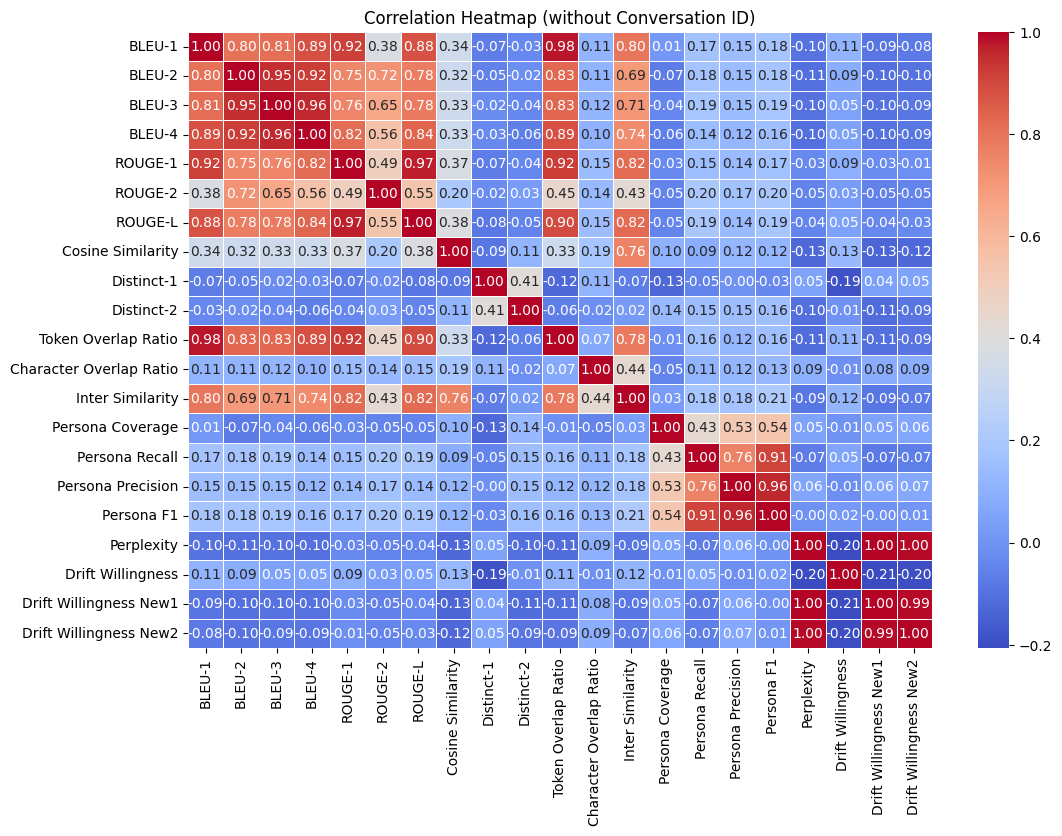

In [38]:
df_no_id
# Calculating the correlation matrix without 'Conversation ID'
correlation_matrix_no_id = df_no_id.corr()

# Generating the heatmap for the updated correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix_no_id, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap (without Conversation ID)")
plt.show()


### Developing Metrics

In [115]:
from helper import read_json
data = read_json('PersonaChat_Metrics/gpt-3.5-turbo-4k/experiment1_context_only')

In [105]:
dialogue_history = data[0]['user_prompt']
dialogue_lines = dialogue_history.split('\n')[1:-1]
dialogue_list_no_labels = [line.split(": ", 1)[1] for line in dialogue_lines]

In [108]:
dialogue_lines[0].split(":",1)[0]

'Bot'

In [89]:
print(dialogue_list_no_labels)

['Hello what are doing today?', 'I am good, I just got off work and tired, I have two jobs.', 'I just got done watching a horror movie.', "I rather read, I've read about 20 books this year.", 'Wow! I do love a good horror movie. Loving this cooler weather.', 'But a good movie is always good.', 'Yes! My son is in junior high and I just started letting him watch them too.', 'I work in the movies as well.', 'Neat!! I used to work in the human services field.', 'Yes it is neat, I stunt double, it is so much fun and hard work.', 'Yes I bet you can get hurt. My wife works and I stay at home.', 'Nice, I only have one parent so now I help out my mom.', 'I bet she appreciates that very much.', 'She raised me right, I am just like her.', 'My dad was always busy working at home depot.']


In [169]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
sentence1 = "Hello"
sentence2 = "Hi"
model_name='all-MiniLM-L6-v2'
model = SentenceTransformer(model_name)
embeddings = model.encode([sentence1, sentence2])
cos_sim = cosine_similarity([embeddings[0]], [embeddings[1]])
print(cos_sim)


[[0.807153]]


In [145]:
import transformers
transformers.logging.set_verbosity_error()
from sklearn.metrics.pairwise import cosine_similarity
from transformers import RobertaTokenizerFast, RobertaModel
from analyze import tokenize, tokenize_with_punctuation
import torch
import numpy as np

from helper import read_json
data = read_json('PersonaChat_Metrics/gpt-4o-latest/experiment1_context_only')

model_name = 'roberta-base'
def get_token_embedding(sentence, model_name):
    sentence = sentence.lower()
    # Load pre-trained RoBERTa model and tokenizer
    tokenizer = RobertaTokenizerFast.from_pretrained(model_name)
    model = RobertaModel.from_pretrained(model_name)
    # Tokenize input
    inputs = tokenizer(sentence, return_tensors='pt')
    # Generate contextualized embeddings
    with torch.inference_mode():
        outputs = model(**inputs)
    # The last_hidden_state contains the embeddings
    token_embedding = outputs.last_hidden_state

    # Convert token IDs to word tokens
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

    return token_embedding, tokens

user_prompt = data[1]['user_prompt']
generated_response = data[1]['generated_response']
log_probs = data[1]['log_probs']


# remove Dialogue History: and User: 
dialogue_lines = user_prompt.split('\n')[1:-1]
# remove the Bot and User labels
dialogue_list_no_labels = [line.split(": ", 1)[1] for line in dialogue_lines]
# Get the last utterance
last_utterance = dialogue_list_no_labels[-1]

last_utterance_embedding, last_utterance_t= get_token_embedding(last_utterance, model_name)

# Compute the sentence embedding by averaging all token embeddings
sentence_embedding = torch.mean(last_utterance_embedding, dim=1)

confident_perplexity_001 = 0.0
confident_perplexity_002 = 0.0

generated_response_embedding, generated_response_t = get_token_embedding(generated_response, model_name)
for idx, token_embedding in enumerate(generated_response_embedding[0]):
    token_embedding = token_embedding.reshape(1, -1)
    sentence_embedding = sentence_embedding.reshape(1, -1)
    print(token_embedding.shape)
    print(sentence_embedding.shape)
    cos_sim = cosine_similarity(sentence_embedding, token_embedding)
    print(f"Cosine Similarity: {cos_sim}")
    confident_perplexity_001 += np.log(cos_sim) + log_probs[idx]
    confident_perplexity_002 += cos_sim * log_probs[idx]

confident_perplexity_001 = np.exp(-confident_perplexity_001/(idx+1))
confident_perplexity_002 = np.exp(-confident_perplexity_002/(idx+1))




torch.Size([1, 768])
torch.Size([1, 768])
Cosine Similarity: [[0.8554826]]
torch.Size([1, 768])
torch.Size([1, 768])
Cosine Similarity: [[0.9108758]]
torch.Size([1, 768])
torch.Size([1, 768])
Cosine Similarity: [[0.8929861]]
torch.Size([1, 768])
torch.Size([1, 768])
Cosine Similarity: [[0.88817716]]
torch.Size([1, 768])
torch.Size([1, 768])
Cosine Similarity: [[0.89450574]]
torch.Size([1, 768])
torch.Size([1, 768])
Cosine Similarity: [[0.9018005]]
torch.Size([1, 768])
torch.Size([1, 768])
Cosine Similarity: [[0.9299068]]
torch.Size([1, 768])
torch.Size([1, 768])
Cosine Similarity: [[0.93454874]]
torch.Size([1, 768])
torch.Size([1, 768])
Cosine Similarity: [[0.9018992]]
torch.Size([1, 768])
torch.Size([1, 768])
Cosine Similarity: [[0.8898985]]
torch.Size([1, 768])
torch.Size([1, 768])
Cosine Similarity: [[0.85201705]]
torch.Size([1, 768])
torch.Size([1, 768])
Cosine Similarity: [[0.90018135]]
torch.Size([1, 768])
torch.Size([1, 768])
Cosine Similarity: [[0.82893634]]
torch.Size([1, 768]

IndexError: list index out of range

In [146]:
generated_response_t


['<s>',
 't',
 'aylor',
 'Ġswift',
 'Ġis',
 'Ġgreat',
 '!',
 'Ġshe',
 "'s",
 'Ġreally',
 'Ġversatile',
 ',',
 'Ġblending',
 'Ġcountry',
 ',',
 'Ġpop',
 ',',
 'Ġand',
 'Ġeven',
 'Ġsome',
 'Ġindie',
 'Ġsounds',
 '.',
 'Ġdo',
 'Ġyou',
 'Ġhave',
 'Ġa',
 'Ġfavorite',
 'Ġsong',
 'Ġor',
 'Ġalbum',
 'Ġby',
 'Ġher',
 '</s>']

In [6]:
from helper import read_json
data = read_json("Raw_Response/personachat_context_only_chatgpt-4o-latest")

In [7]:
list = [[token['token'], token['logprob']] for token in data[0]['raw_response']['choices'][0]['logprobs']['content']]

In [12]:
from transformers import RobertaTokenizerFast, RobertaModel
import torch

# Initialize RoBERTa tokenizer and model
tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base')
model = RobertaModel.from_pretrained('roberta-base')

# List of tokens from GPT
gpt_tokens = [token['token'] for token in data[2]['raw_response']['choices'][0]['logprobs']['content']]

# Combine tokens back into a sentence
sentence = "".join(gpt_tokens)

# Tokenize using RoBERTa
roberta_inputs = tokenizer(sentence, return_tensors='pt')

# Get the contextualized embeddings
with torch.no_grad():
    outputs = model(**roberta_inputs)
    roberta_embeddings = outputs.last_hidden_state  # (batch_size, sequence_length, hidden_size)

# Convert RoBERTa token IDs back to tokens for alignment
roberta_tokens = tokenizer.convert_ids_to_tokens(roberta_inputs['input_ids'][0][1:])

# Now, align the GPT tokens with RoBERTa tokens and extract embeddings
aligned_embeddings = []
roberta_index = 0

for gpt_token in gpt_tokens:
    gpt_token = gpt_token.replace(" ", "")
    # Merge RoBERTa tokens to match GPT token
    current_roberta_token = roberta_tokens[roberta_index].replace("Ġ", "")

    embedding_sum = roberta_embeddings[0, roberta_index].numpy()
    token_count = 1
    print("prev ",current_roberta_token, " replaced length ", len(current_roberta_token.replace("Ġ", "")))
    print("current embedding ", embedding_sum[0])
    print("roberta_index ", roberta_index)
    print("gpt_token ", gpt_token, " the length is ", len(gpt_token))
    while roberta_index + 1 < len(roberta_tokens) and len(current_roberta_token) < len(gpt_token):
        roberta_index += 1
        current_roberta_token += roberta_tokens[roberta_index]
        embedding_sum += roberta_embeddings[0, roberta_index].numpy()
        token_count += 1
        print("replaced")
    print("after ", current_roberta_token)
    
    averaged_embedding = embedding_sum / token_count
    print("after embedding ", averaged_embedding[0])
    # Append the corresponding embedding
    aligned_embeddings.append(roberta_embeddings[0, roberta_index].numpy())
    
    # Move to the next RoBERTa token
    roberta_index += 1
    print()

# aligned_embeddings now contains the contextualized embeddings for the GPT tokens
print("Aligned Embeddings Shape:", len(aligned_embeddings), aligned_embeddings[0].shape)


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


prev  It  replaced length  2
current embedding  -0.08313644
roberta_index  0
gpt_token  It  the length is  2
after  It
after embedding  -0.08313644

prev  sounds  replaced length  6
current embedding  -0.26006776
roberta_index  1
gpt_token  sounds  the length is  6
after  sounds
after embedding  -0.26006776

prev  like  replaced length  4
current embedding  0.05929163
roberta_index  2
gpt_token  like  the length is  4
after  like
after embedding  0.05929163

prev  you  replaced length  3
current embedding  -0.019812904
roberta_index  3
gpt_token  you're  the length is  6
replaced
after  you're
after embedding  -0.036794443

prev  working  replaced length  7
current embedding  -0.058523998
roberta_index  5
gpt_token  working  the length is  7
after  working
after embedding  -0.058523998

prev  really  replaced length  6
current embedding  0.06588697
roberta_index  6
gpt_token  really  the length is  6
after  really
after embedding  0.06588697

prev  hard  replaced length  4
current embe

In [11]:
current_roberta_toke

"you're"

In [207]:
len(aligned_embeddings)

30

In [200]:
#aligned_embeddings.__len__()
gpt_tokens.__len__()

30

In [188]:
roberta_tokens

['<s>',
 'It',
 'Ġsounds',
 'Ġlike',
 'Ġyou',
 "'re",
 'Ġworking',
 'Ġreally',
 'Ġhard',
 ',',
 'Ġand',
 'Ġit',
 "'s",
 'Ġnot',
 'Ġeasy',
 'Ġwith',
 'Ġthe',
 'Ġchallenges',
 'Ġyou',
 "'re",
 'Ġfacing',
 '.',
 'ĠBeing',
 'Ġa',
 'Ġbaby',
 'Ġdelivery',
 'Ġnurse',
 'Ġis',
 'Ġsuch',
 'Ġan',
 'Ġimportant',
 'Ġjob',
 'âĢĶ',
 'you',
 "'re",
 '</s>']

In [117]:
#print(generated_response_t.word_ids()[0])
word_ids = {i for i in generated_response_t.word_ids() if i is not None}
word_embeddings = {}
for word_id in word_ids:
    token_start, token_end = generated_response_t.word_to_tokens(word_id)
    word_start, word_end =  generated_response_t.word_to_chars(word_id)
    
    word=generated_response[word_start:word_end]
    
    word_embeddings[word] = generated_response_embedding[token_start:token_end].mean(dim=0)
    print(f"the word is {word}, embedding is {word_embeddings[word]}")
    

the word is It, embedding is tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])
the word is sounds, embedding is tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])
the word is like, embedding is tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])
the word is you, embedding is tensor(

In [114]:
word_start, word_end

(0, 2)

In [84]:
print(generated_response_embedding[0].shape)
print(log_probss.)

torch.Size([34, 768])
30


In [59]:
from analyze import tokenize
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
model = RobertaModel.from_pretrained("roberta-base")
sentence = "Hello there World"
inputs = tokenizer(sentence, return_tensors='pt', padding="longest")
with torch.inference_mode():
  model_inference_output = model(**inputs)
  contextualized_token_embeddings = model_inference_output.last_hidden_state

input_ids = inputs['input_ids'][0]

# Convert token IDs back to tokens
tokens = tokenizer.convert_ids_to_tokens(input_ids)

# Print the tokens
print("Tokens:", tokens)

# Combine subword tokens back into words
words = tokenizer.convert_tokens_to_string(tokens)
print("Reconstructed sentence:", words)

Tokens: ['<s>', 'Hello', 'Ġthere', 'ĠWorld', '</s>']
Reconstructed sentence: <s>Hello there World</s>


In [63]:
contextualized_token_embeddings[0][0].shape


torch.Size([768])

In [38]:
sentence_embedding = torch.mean(contextualized_token_embeddings, dim=1)

In [46]:
sentence_embedding[0][0]

tensor(-0.0173)

In [199]:
inputs

{'input_ids': tensor([[    0, 20770,   703,    10,    92,  2733,     4,     2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]])}

In [181]:
last_hidden_state.shape

torch.Size([1, 8, 768])

In [175]:
print(inputs)

{'input_ids': tensor([[    0, 20770,   703,    10,    92,  2733,     4,     2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]])}


In [110]:
result

0.807153

In [103]:
### New metric to measure how likely the user is willing to start new topic
# start from 0 to indicate bot as first, start from 1 to indicate user as first
# 0 indicates how user 
history_convo = dialogue_list_no_labels
cos_sim_list = []
count = 0
firstspeaker_name = "User"
for i in range(0 if firstspeaker_name == "Bot" else 1,len(history_convo)-1,2):
    firstspeaker_uttr = history_convo[i]
    secondspeaker_uttr =  history_convo[i+1]
    cos_sim = cosine_similarity_embeddings(firstspeaker_uttr, secondspeaker_uttr)
    cos_sim_list.append(cos_sim)
    print(f"Pair {count}:")
    print(firstspeaker_uttr)
    print(secondspeaker_uttr)
    count += 1

avg_willingness = sum(cos_sim_list)/len(cos_sim_list)

print(avg_willingness)

Pair 0:
I am good, I just got off work and tired, I have two jobs.
I just got done watching a horror movie.
Pair 1:
I rather read, I've read about 20 books this year.
Wow! I do love a good horror movie. Loving this cooler weather.
Pair 2:
But a good movie is always good.
Yes! My son is in junior high and I just started letting him watch them too.
Pair 3:
I work in the movies as well.
Neat!! I used to work in the human services field.
Pair 4:
Yes it is neat, I stunt double, it is so much fun and hard work.
Yes I bet you can get hurt. My wife works and I stay at home.
Pair 5:
Nice, I only have one parent so now I help out my mom.
I bet she appreciates that very much.
Pair 6:
She raised me right, I am just like her.
My dad was always busy working at home depot.
0.20369993788855417


In [97]:
cos_sim_list
avg_willingness = sum(cos_sim_list)/len(cos_sim_list)
print(avg_willingness)

0.20369993788855417


In [87]:
dialogue_lines

['Bot: Hello what are doing today?',
 'User: I am good, I just got off work and tired, I have two jobs.',
 'Bot: I just got done watching a horror movie.',
 "User: I rather read, I've read about 20 books this year.",
 'Bot: Wow! I do love a good horror movie. Loving this cooler weather.',
 'User: But a good movie is always good.',
 'Bot: Yes! My son is in junior high and I just started letting him watch them too.',
 'User: I work in the movies as well.',
 'Bot: Neat!! I used to work in the human services field.',
 'User: Yes it is neat, I stunt double, it is so much fun and hard work.',
 'Bot: Yes I bet you can get hurt. My wife works and I stay at home.',
 'User: Nice, I only have one parent so now I help out my mom.',
 'Bot: I bet she appreciates that very much.',
 'User: She raised me right, I am just like her.',
 'Bot: My dad was always busy working at home depot.']

In [19]:
filenames = ['PersonaChat_Metrics/gpt-3.5-turbo-4k/experiment1_context_only_metrics', 'PersonaChat_Metrics/gpt-3.5-turbo-4k/experiment1_task_prompt_context_implicit_metrics']
new_names = filenames[0]

In [20]:
new_names

'PersonaChat_Metrics/gpt-3.5-turbo-4k/experiment1_context_only_metrics'

In [24]:
from transformers import pipeline
classifier = pipeline("sentiment-analysis", model="michellejieli/emotion_text_classifier")
result = classifier("I hate this")

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [28]:
result[0]

{'label': 'disgust', 'score': 0.855880856513977}

In [69]:
import json
import os
from openai import OpenAI
with open('config.json', 'r') as file:
    config = json.load(file)

os.environ['OPENAI_API_KEY'] = config['api_key']
client = OpenAI()

system_prompt = "The response is happy"
user_prompt = "What do you think of apple?"

response = client.chat.completions.create(
        model = "gpt-4o-mini-2024-07-18",
        #model="gpt-3.5-turbo-0613", 
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt}
        ],
        temperature=0.9,  
        #max_tokens=30, # since persona-chat sets a maximum of 15 words per message
        max_tokens=30,
        logprobs=True,
        top_logprobs=5
    )

generated_response = response.choices[0].message.content

In [ ]:
print(response)

In [71]:
print(response.choices[0].logprobs.content[1])

ChatCompletionTokenLogprob(token=' think', bytes=[32, 116, 104, 105, 110, 107], logprob=-4.6444635e-05, top_logprobs=[TopLogprob(token=' think', bytes=[32, 116, 104, 105, 110, 107], logprob=-4.6444635e-05), TopLogprob(token=' have', bytes=[32, 104, 97, 118, 101], logprob=-10.375047), TopLogprob(token=' really', bytes=[32, 114, 101, 97, 108, 108, 121], logprob=-12.250047), TopLogprob(token=' find', bytes=[32, 102, 105, 110, 100], logprob=-12.375047), TopLogprob(token=' believe', bytes=[32, 98, 101, 108, 105, 101, 118, 101], logprob=-12.875047)])


In [72]:
log_probs = []
for log_prob in response.choices[0].logprobs.content:
    log_probs.append(log_prob.logprob)

In [73]:
log_probs

[-0.07929633,
 -4.6444635e-05,
 -0.5119898,
 -1.3856493e-06,
 -0.60324043,
 -8.776276e-06,
 -0.57683784,
 -1.7106117,
 -0.19316357,
 -0.00029637438,
 -0.0016792254,
 -0.31765103,
 -0.05439886,
 -1.1743832,
 -6.3609965e-05,
 -0.013037274,
 -1.8624639e-06,
 -0.034045365,
 -0.030705579,
 -0.045336414,
 -0.40194777,
 -0.014475973,
 -0.00014203864,
 -0.13221091,
 -1.5928495e-05,
 -0.13569869,
 -0.31481925,
 -0.0006915859,
 -4.3202e-07,
 -0.0076660137]

In [74]:
import math
def calculate_perplexity(log_probs):
    """
    Calculate the perplexity from a list of log probabilities.

    :param log_probs: List of log probabilities of tokens
    :return: Perplexity value
    """
    # Number of tokens
    N = len(log_probs)
    
    # Calculate the average log probability
    avg_log_prob = sum(log_probs) / N
    
    # Calculate perplexity
    perplexity = np.exp(-avg_log_prob)
    
    return perplexity

result = calculate_perplexity(log_probs)

In [12]:
from analyze import calculate_aligned_embedding
from helper import read_json

data = read_json("experiment1_task_prompt_context_implicit_gpt-3.5-turbo-1106_0819-0046")

In [13]:
calculate_aligned_embedding(data[-1]['tokens_list'])

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


prev  Have
current embedding  -0.07340113
roberta_index  0
gpt_token  Have
Aligned 'Have' to 'Have', averaged embedding shape: (768,)
prev  you
current embedding  0.09222092
roberta_index  1
gpt_token  you
Aligned 'you' to 'you', averaged embedding shape: (768,)
prev  tried
current embedding  -0.07583424
roberta_index  2
gpt_token  tried
Aligned 'tried' to 'tried', averaged embedding shape: (768,)
prev  out
current embedding  -0.044010594
roberta_index  3
gpt_token  out
Aligned 'out' to 'out', averaged embedding shape: (768,)
prev  the
current embedding  -0.04369279
roberta_index  4
gpt_token  the
Aligned 'the' to 'the', averaged embedding shape: (768,)
prev  new
current embedding  -0.030674644
roberta_index  5
gpt_token  new
Aligned 'new' to 'new', averaged embedding shape: (768,)
prev  Starcraft
current embedding  0.055648834
roberta_index  6
gpt_token  Star
Aligned 'Starcraft' to 'Starcraft', averaged embedding shape: (768,)
prev  expansion
current embedding  0.08643676
roberta_inde

[array([-7.34011307e-02,  9.72081497e-02, -1.85587183e-02, -1.02512442e-01,
         2.53388211e-02, -5.69405593e-02, -9.88692045e-03,  1.26771592e-02,
         7.99935311e-02, -7.34448060e-02, -2.61633098e-02,  5.87808900e-02,
         3.44967730e-02, -4.52789292e-02,  8.01239610e-02,  2.06770524e-02,
        -7.79184848e-02,  1.43989176e-02,  1.71890259e-02, -3.71786729e-02,
        -1.34509370e-01,  1.67879947e-02, -4.94140536e-02,  7.89122581e-02,
        -2.19844654e-03,  1.00184856e-02,  6.17353842e-02,  5.55457287e-02,
        -2.60763541e-02, -2.08069310e-02, -5.28337434e-02, -2.50097737e-02,
         3.99552286e-02, -5.42305931e-02,  2.91824304e-02,  3.19760442e-02,
         2.25422159e-02,  1.06860884e-02, -9.91908386e-02,  8.90045427e-03,
         3.87762748e-02,  6.30263537e-02, -4.05377150e-03,  1.86093282e-02,
         8.86845440e-02,  1.41042098e-02,  2.67219990e-02, -8.42235982e-03,
        -4.00078669e-02,  2.79617421e-02,  1.08372997e-02,  9.63748693e-02,
        -5.2